In [1]:
# !pip install skater
# if you face an issue with this you can download skater master from here :https://github.com/oracle/Skater
# go that folder on your command prompt and run 
# python setup.py install
# also if you build skater like that , you'll need to restart your kernel for imports to start working

# for windows users if you get error : command not recognised 
# you need to add python to your environment variable path 

# follow this link to do the same : https://geek-university.com/python/add-python-to-the-windows-path/

# you will to have to also figure out where python is installed on your machine 


In [2]:
#pip install git+https://github.com/oracle/skater.git

In [3]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import warnings 
warnings.filterwarnings('ignore')
from mypipes import *

In [4]:
file=r'../data/census_income.csv'

ci=pd.read_csv(file)
ci=ci.sample(1000)

In [5]:
ci['Y'].unique()

array([' >50K', ' <=50K'], dtype=object)

In [6]:
cat_vars=list(ci.select_dtypes(include=['object']).columns)

In [7]:
cat_vars=[_ for _ in cat_vars if _ not in ['Y','education']]

In [35]:
cat_vars

['workclass',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

In [8]:
num_vars=list(ci.select_dtypes(exclude=['object']).columns)

In [9]:
p1=pdPipeline([
    ('cat_select',VarSelector(cat_vars)),
    ('missing_trt',DataFrameImputer()),
    ('create_dummies',get_dummies_Pipe(100))
])

p2=pdPipeline([
    ('num_select',VarSelector(num_vars)),
    ('missing_trt',DataFrameImputer())
])

data_pipe=FeatureUnion([
    ('cat_pipe',p1),
    ('num_pipe',p2)
])

In [10]:
data_pipe.fit(ci)

FeatureUnion(transformer_list=[('cat_pipe',
                                pdPipeline(steps=[('cat_select',
                                                   VarSelector(feature_names=['workclass',
                                                                              'marital.status',
                                                                              'occupation',
                                                                              'relationship',
                                                                              'race',
                                                                              'sex',
                                                                              'native.country'])),
                                                  ('missing_trt',
                                                   DataFrameImputer()),
                                                  ('create_dummies',
                                         

In [11]:
x=pd.DataFrame(data=data_pipe.transform(ci),
                     columns=data_pipe.get_feature_names())
y=(ci['Y']==" >50K").astype(int)


In [12]:
y.value_counts()

0    755
1    245
Name: Y, dtype: int64

In [13]:
rf=RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 14, 'max_features': 11, 'n_estimators': 320})

In [14]:
rf.fit(x,y)

RandomForestClassifier(criterion='entropy', max_depth=14, max_features=11,
                       n_estimators=320)

In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [16]:
#!pip install skater

In [17]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

# if you get the error : ModuleNotFoundError: No module named 'sklearn.externals.six'

# do the following : go the file in your folder where the error is coming from 
# for me the issue was on top line of this file :

# ~/anaconda3/lib/python3.7/site-packages/skater-1.1.2b1-py3.7.egg/skater/core/visualizer/tree_visualizer.py
# change the line : from sklearn.externals.six import StringIO

# to : from six import StringIO
# save and restart the kernel 

# if you further get and error that no module named six then run :
# !pip install six

2023-07-08 19:46:53,769 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[23/23] features ████████████████████ Time elapsed: 6 seconds

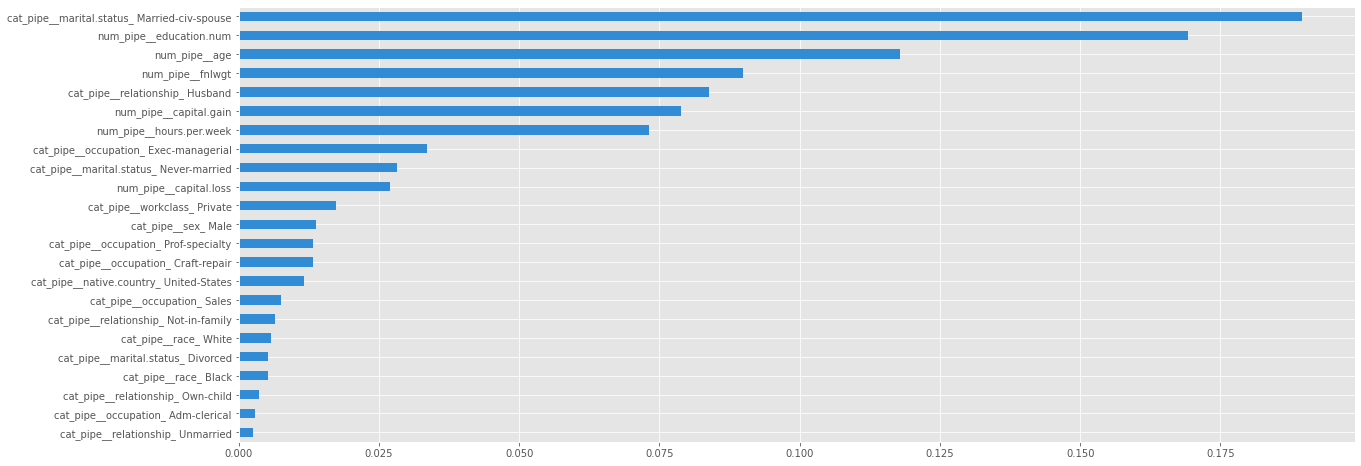

In [18]:
interpreter = Interpretation(x, feature_names=x.columns)
model = InMemoryModel(rf.predict_proba, examples=x)
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True)


2023-07-08 19:47:01,916 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[16/16] grid cells ████████████████████ Time elapsed: 6 seconds

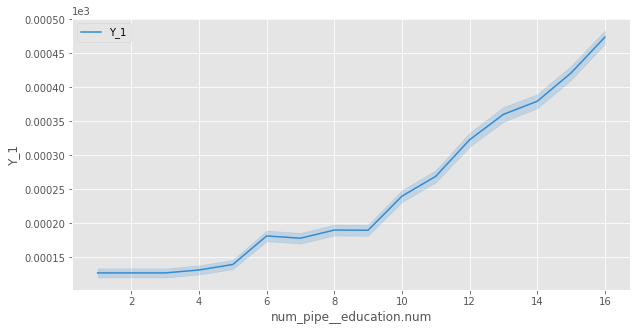

In [19]:
pyint_model = InMemoryModel(rf.predict_proba, examples=x, target_names=['Y_0','Y_1'])
axes_list = interpreter.partial_dependence.plot_partial_dependence(['num_pipe__education.num'],
                                                                   pyint_model, 
                                                                   grid_resolution=30, 
                                                                   with_variance=True,
                                                                   figsize = (10, 5))


2023-07-08 19:47:09,623 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[30/30] grid cells ████████████████████ Time elapsed: 9 seconds

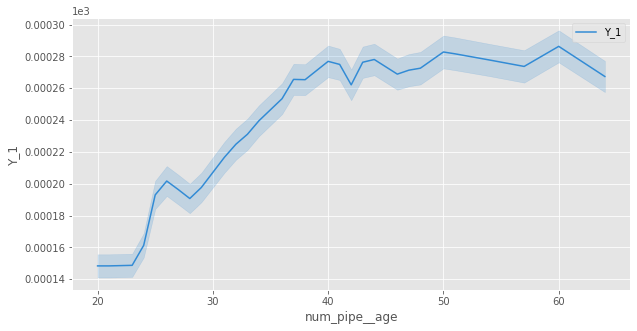

In [20]:
axes_list = interpreter.partial_dependence.plot_partial_dependence(['num_pipe__age'],
                                                                   pyint_model, 
                                                                   grid_resolution=30, 
                                                                   with_variance=True,
                                                                   figsize = (10, 5))

2023-07-08 19:47:20,254 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[60/60] grid cells ████████████████████ Time elapsed: 15 seconds

[[<Figure size 1152x720 with 2 Axes>,
  <Axes3DSubplot:xlabel='num_pipe__age', ylabel='num_pipe__education.num'>]]

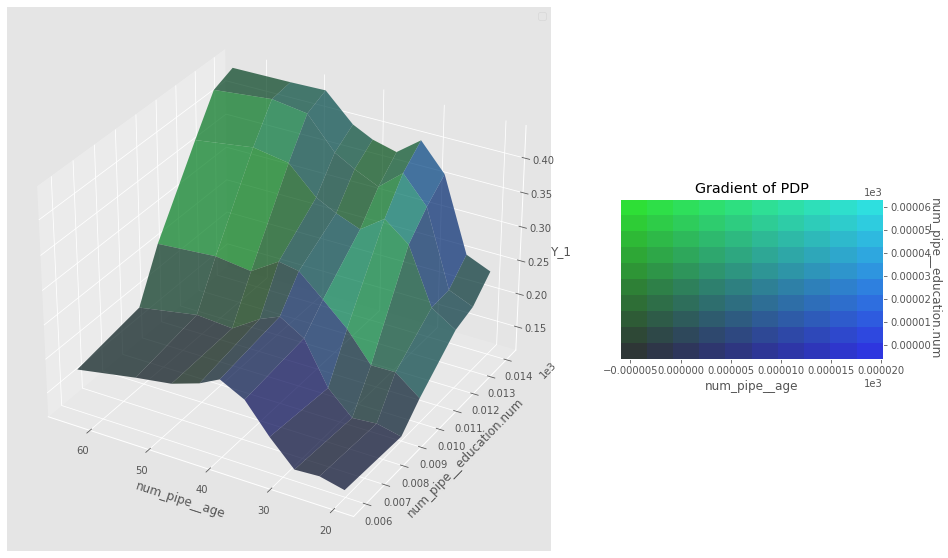

In [21]:
model = InMemoryModel(rf.predict_proba, examples=x,
                      target_names=['Y_0', 'Y_1'])
interpreter.partial_dependence.plot_partial_dependence([('num_pipe__age', 'num_pipe__education.num')], model, 
                                                       grid_resolution=10)

In [22]:
from skater.util.dataops import show_in_notebook

In [23]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.util.dataops import show_in_notebook
exp = LimeTabularExplainer(x.values, 
                           feature_names=x.columns, 
                           discretize_continuous=True, 
                           class_names=['Y_0', 'Y_1'])

In [36]:
exp.explain_instance?

In [38]:
exp.explain_instance(x.iloc[10].values, rf.predict_proba).show_in_notebook()

In [37]:
exp.explain_instance(x.iloc[100].values, rf.predict_proba).show_in_notebook()

In [26]:
from skater.core.global_interpretation.tree_surrogate import TreeSurrogate

surrogate_explainer = interpreter.tree_surrogate(oracle=model,max_depth=8)
y_pred_rf=rf.predict(x)

surrogate_explainer.fit(x, y_pred_rf, use_oracle=True, prune='post', scorer_type='default')

# if you get this error : TypeError: __init__() got an unexpected keyword argument 'presort'

# go to tree_surrogate.py file here : 
# ~/anaconda3/lib/python3.7/site-packages/skater-1.1.2b1-py3.7.egg/skater/core/global_interpretation/

# and remove the presort input to DecisionTreeClassfier/Regressor

2023-07-08 19:47:40,618 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2023-07-08 19:47:40,623 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2023-07-08 19:47:40,625 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 0.23604192758844927
2023-07-08 19:47:40,755 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [6, 8, 12, 19, 22, 41, 68, 75, 100, 103, 117]
2023-07-08 19:47:40,756 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (1000, 2)
2023-07-08 19:47:40,759 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.245; oracle score 0.118


-0.127

In [34]:
?surrogate_explainer

In [29]:
# if you get graphviz error on mac : please install by running this : sudo brew install graphviz
# if that gives error for brew not found , install homebrew
surrogate_explainer.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'],
                                          file_name='simple_tree_pre.png')

ValueError: invalid literal for int() with base 10: '"\\n"'

In [28]:
show_in_notebook('simple_tree_pre.png', width=400, height=300)

2023-07-08 19:48:34,164 - skater.util.dataops - INFO - File Name: simple_tree_pre.png


FileNotFoundError: No such file or directory: 'simple_tree_pre.png'

FileNotFoundError: No such file or directory: 'simple_tree_pre.png'

<IPython.core.display.Image object>

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
accuracy_score(rf.predict(x),y)

0.985

In [32]:
accuracy_score(surrogate_explainer.predict(x),y)

0.863